In [1]:
# !pip install torch pandas seaborn gym -q

In [1]:
import torch
import gym
import numpy as np
from collections import deque
import random
import copy
import seaborn as sns
import pandas as pd

In [2]:
class ReplayBuffer:
    def __init__(self, size=1000000):
        self.memory = deque(maxlen=size)
        
    def remember(self, s_t, a_t, r_t, s_t_next, d_t):
        self.memory.append((s_t, a_t, r_t, s_t_next, d_t))
        
    def sample(self, num=32):
        num = min(num, len(self.memory))
        return random.sample(self.memory, num)

In [3]:
class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, make_env, num_envs=1):
        super().__init__(make_env())
        self.num_envs = num_envs
        self.envs = [make_env() for env_index in range(num_envs)]
    
    def reset(self):
        return np.asarray([env.reset() for env in self.envs])
    
    def step(self, actions):
        next_states, rewards, dones = [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, _ = env.step(action)
            if done:
                next_states.append(env.reset())
            else:
                next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones)

In [4]:
def plot(data, window=100):
    sns.lineplot(
        data=data.rolling(window=window).mean()[window-1::window]
    )

In [15]:
def train(env_name, T=20000, num_envs=32, batch_size=32, sync_every=100, alpha=0.001, gamma=0.95):
    env = VectorizedEnvWrapper(lambda: gym.make(env_name), num_envs)
    state_shape = env.observation_space.shape
    num_actions = env.action_space.n
    agent = Agent(state_shape, num_actions, num_envs, alpha=alpha, gamma=gamma)
    rewards = []
    buffer = ReplayBuffer()
    episode_rewards = 0
    s_t = env.reset()
    for t in range(T):
        if t%(T//1000) == 0:
            print(f'{100*t/T}%\r', end='')
        if t%sync_every == 0:
            agent.synchronize()
        
        a_t = agent.act(s_t)
        s_t_next, r_t, d_t = env.step(a_t)
        buffer.remember(s_t, a_t, r_t, s_t_next, d_t)
        s_t = s_t_next
        for batch in buffer.sample(batch_size):
            agent.update(*batch)
        agent.decay_epsilon(t/T)
        episode_rewards += r_t

        for i in range(env.num_envs):
            if d_t[i]:
                rewards.append(episode_rewards[i])
                episode_rewards[i] = 0
            
    plot(pd.DataFrame(rewards), window=10)
    return agent

In [6]:
class Agent:
    def __init__(self, state_shape, num_actions, num_envs, alpha=0.001, gamma=0.95, epsilon_i=1.0, epsilon_f=0.00, n_epsilon=0.1):
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.n_epsilon = n_epsilon
        self.epsilon = epsilon_i
        self.gamma = gamma

        self.num_actions = num_actions
        self.num_envs = num_envs

        self.Q = torch.nn.Sequential(
            torch.nn.Linear(*state_shape, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, num_actions)
        ).double()
        
        self.Q_ = copy.deepcopy(self.Q)
        
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=alpha)
    
    def synchronize(self):
        self.Q_.load_state_dict(self.Q.state_dict())

    def act(self, s_t):
        s_t = torch.as_tensor(s_t).double()
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions, size=self.num_envs)
        else:
            with torch.no_grad():
                return np.argmax(self.Q(s_t).numpy(), axis=1)
    
    def decay_epsilon(self, n):
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))

    def update(self, s_t, a_t, r_t, s_t_next, d_t):
        s_t = torch.as_tensor(s_t).double()
        a_t = torch.as_tensor(a_t).long()
        r_t = torch.as_tensor(r_t).double()
        s_t_next = torch.as_tensor(s_t_next).double()
        d_t = torch.as_tensor(d_t).double()
        
        with torch.no_grad():
            Q_next = torch.max(self.Q_(s_t_next), dim=1)[0]
        Q_pred = self.Q(s_t)[range(self.num_envs), a_t]
        target = r_t + (1-d_t)*self.gamma*Q_next
        
        loss = torch.mean(0.5*(target - Q_pred)**2)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

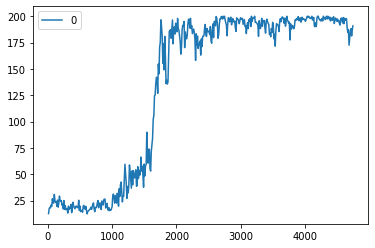

In [7]:
agent = train("CartPole-v0", T=20000, num_envs=32, batch_size=1, alpha=0.001)

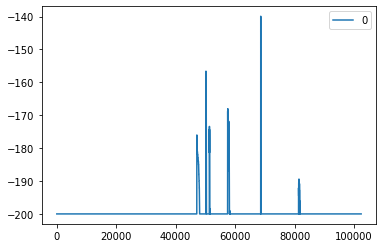

In [20]:
agent = train("MountainCar-v0", T=20000, num_envs=1024, batch_size=10, alpha=0.001)

In [21]:
env_name = "MountainCar-v0"
T=2000
num_envs=32
batch_size=32
sync_every=100
alpha=0.001
gamma=0.95

env = VectorizedEnvWrapper(lambda: gym.make(env_name), num_envs)
state_shape = env.observation_space.shape
num_actions = env.action_space.n
rewards = []
positions = []
episode_rewards = 0
s_t = env.reset()
for t in range(T):
    if t%(T//1000) == 0:
        print(f'{100*t/T}%\r', end='')
    a_t = agent.act(s_t)
    s_t, r_t, d_t = env.step(a_t)
    episode_rewards += r_t

    for i in range(env.num_envs):
        if d_t[i]:
            rewards.append(episode_rewards[i])
            episode_rewards[i] = 0
            positions.append(s_t[i][0])

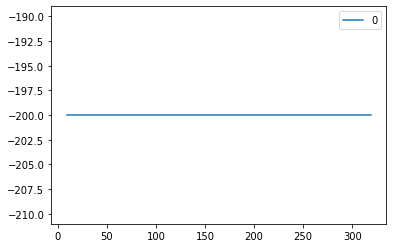

In [22]:
plot(pd.DataFrame(rewards), window=10)